Point of this notebook is to confirm our HMRI equations in the old streamfunction format. Uglier for the linear equations but they work for the nonlinear terms.

In [5]:
import numpy as np
print(np)
%matplotlib nbagg
import matplotlib
from scipy import special

<module 'numpy' from '/Users/susanclark/dedalus_upgraded2/dedalus/lib/python3.5/site-packages/numpy/__init__.py'>


In [6]:
import dedalus.public as de
import numpy as np
import matplotlib.pylab as plt

In [7]:
nr1 = 64
r_shortgrid = de.Chebyshev('r', nr1, interval=(1, 2))
d1 = de.Domain([r_shortgrid])

nr2 = 92
r_longgrid = de.Chebyshev('r', nr2, interval=(1, 2))
d2 = de.Domain([r_longgrid])

In [8]:
# critical parameters
r1 = 1.
r2 = 2.

mu_omega = 0.27
eta_omega = r1/r2

c1 = (mu_omega - eta_omega**2)/(1 - eta_omega**2)
c2 = ((1 - mu_omega)/(1 - eta_omega**2))*r1**2

# Hollerbach & Rudiger 2005
Pm = 1.0E-6
Re = 1521
xi = 4
Q = 2.33
k = Q

iR = 1.0/Re
Rm = Pm*Re
iRm = 1.0/Rm

Ha = 16.3
beta = (2*Re*Rm)/(Ha**2)

magnetic_bcs = "insulating"
#magnetic_bcs = "conducting"

In [10]:
widegap1 = de.EVP(d1,['psi','u', 'A', 'B', 'psir', 'psirr', 'psirrr', 'ur', 'Ar', 'Br'],'sigma')
widegap2 = de.EVP(d2,['psi','u', 'A', 'B', 'psir', 'psirr', 'psirrr', 'ur', 'Ar', 'Br'],'sigma')

for widegap in [widegap1, widegap2]:
    widegap.parameters['k'] = Q
    widegap.parameters['iR'] = iR
    widegap.parameters['iRm'] = iRm
    widegap.parameters['beta'] = beta
    widegap.parameters['c1'] = c1
    widegap.parameters['c2'] = c2
    widegap.parameters['B0'] = 1
    widegap.parameters['xi'] = xi
    widegap.parameters['r1'] = r1
    widegap.parameters['r2'] = r2
    #widegap.parameters['bessel1'] = special.iv
    widegap.parameters['bessel1'] = special.iv(0, k*r1)/special.iv(1, k*r1)
    widegap.parameters['bessel2'] = special.kn(0, k*r2)/special.kn(1, k*r2)
    
    widegap.substitutions['ru0'] = '(r*r*c1 + c2)' # u0 = r Omega(r) = Ar + B/r
    widegap.substitutions['rrdu0'] = '(c1*r*r-c2)' # du0/dr = A - B/r^2
    widegap.substitutions['twooverbeta'] = '(2.0/beta)'
    widegap.substitutions['dz'] = '(1j*k)'
    widegap.substitutions['psivisc'] = '(2*r**2*k**2*psir - 2*r**3*k**2*psirr + r**3*k**4*psi + r**3*dr(psirrr) - 3*psir + 3*r*psirr - 2*r**2*psirrr)'
    widegap.substitutions['uvisc'] = '(-r**3*k**2*u + r**3*dr(ur) + r**2*ur - r*u)'
    widegap.substitutions['Avisc'] = '(r*dr(Ar) - r*k**2*A - Ar)' 
    widegap.substitutions['Bvisc'] = '(-r**3*k**2*B + r**3*dr(Br) + r**2*Br - r*B)'

    widegap.add_equation("sigma*(-r**3*k**2*psi + r**3*psirr - r**2*psir) - r**2*2*ru0*1j*k*u + r**3*twooverbeta*B0*1j*k**3*A + twooverbeta*B0*r**2*1j*k*Ar - twooverbeta*r**3*B0*1j*k*dr(Ar) - iR*psivisc + twooverbeta*r**2*2*xi*B0*1j*k*B = 0") #corrected on whiteboard 5/6
    widegap.add_equation("sigma*r**3*u + 1j*k*ru0*psi + 1j*k*rrdu0*psi - 1j*k*r**3*twooverbeta*B0*B - iR*uvisc = 0") 
    widegap.add_equation("sigma*r*A - r*B0*1j*k*psi - iRm*Avisc = 0")
    widegap.add_equation("sigma*r**3*B + ru0*1j*k*A - r**3*B0*1j*k*u - 1j*k*rrdu0*A - iRm*Bvisc - 2*xi*B0*1j*k*psi = 0") 

    widegap.add_equation("dr(psi) - psir = 0")
    widegap.add_equation("dr(psir) - psirr = 0")
    widegap.add_equation("dr(psirr) - psirrr = 0")
    widegap.add_equation("dr(u) - ur = 0")
    widegap.add_equation("dr(A) - Ar = 0")
    widegap.add_equation("dr(B) - Br = 0")
    
    widegap.add_bc('left(u) = 0')
    widegap.add_bc('right(u) = 0')
    widegap.add_bc('left(psi) = 0')
    widegap.add_bc('right(psi) = 0')
    widegap.add_bc('left(psi + r*psir) = 0')
    widegap.add_bc('right(psi + r*psir) = 0')
    if magnetic_bcs == "conducting":
        widegap.add_bc('left(A) = 0')
        widegap.add_bc('right(A) = 0')
        widegap.add_bc('left(B + r*Br) = 0')
        widegap.add_bc('right(B + r*Br) = 0')

    if magnetic_bcs == "insulating":
        widegap.add_bc('left(dr(r*dz*A) - k*r*bessel1*dz*A) = 0')
        widegap.add_bc('right(dr(r*dz*A) + k*r*bessel2*dz*A) = 0')
        widegap.add_bc('left(B) = 0')
        widegap.add_bc('right(B) = 0')


2016-06-21 18:16:55,754 problems 0/1 INFO :: Solving EVP with homogeneity tolerance of 1.000e-10
2016-06-21 18:16:55,756 problems 0/1 INFO :: Solving EVP with homogeneity tolerance of 1.000e-10


In [11]:
widegap_solver1 = widegap1.build_solver()
widegap_solver2 = widegap2.build_solver()

In [12]:
widegap_solver1.solve(widegap_solver1.pencils[0])
widegap_solver2.solve(widegap_solver2.pencils[0])

/Users/susanclark/dedalus_upgraded2/dedalus/lib/python3.5/site-packages/scipy/linalg/decomp.py:56: RuntimeWarning: divide by zero encountered in true_divide
  w = alpha / beta


In [13]:
ev1 = widegap_solver1.eigenvalues
ev2 = widegap_solver2.eigenvalues

In [14]:
def discard_spurious_eigenvalues(lambda1, lambda2):
    
    """
    lambda1 :: eigenvalues from low res run
    lambda2 :: eigenvalues from high res run

    Solves the linear eigenvalue problem for two different resolutions.
    Returns trustworthy eigenvalues using nearest delta, from Boyd chapter 7.
    """

    # Reverse engineer correct indices to make unsorted list from sorted
    reverse_lambda1_indx = np.arange(len(lambda1)) 
    reverse_lambda2_indx = np.arange(len(lambda2))

    lambda1_and_indx = np.asarray(list(zip(lambda1, reverse_lambda1_indx)))
    lambda2_and_indx = np.asarray(list(zip(lambda2, reverse_lambda2_indx)))

    # remove nans
    lambda1_and_indx = lambda1_and_indx[np.isfinite(lambda1)]
    lambda2_and_indx = lambda2_and_indx[np.isfinite(lambda2)]

    # Sort lambda1 and lambda2 by real parts
    lambda1_and_indx = lambda1_and_indx[np.argsort(lambda1_and_indx[:, 0].real)]
    lambda2_and_indx = lambda2_and_indx[np.argsort(lambda2_and_indx[:, 0].real)]

    lambda1_sorted = lambda1_and_indx[:, 0]
    lambda2_sorted = lambda2_and_indx[:, 0]

    # Compute sigmas from lower resolution run (gridnum = N1)
    sigmas = np.zeros(len(lambda1_sorted))
    sigmas[0] = np.abs(lambda1_sorted[0] - lambda1_sorted[1])
    sigmas[1:-1] = [0.5*(np.abs(lambda1_sorted[j] - lambda1_sorted[j - 1]) + np.abs(lambda1_sorted[j + 1] - lambda1_sorted[j])) for j in range(1, len(lambda1_sorted) - 1)]
    sigmas[-1] = np.abs(lambda1_sorted[-2] - lambda1_sorted[-1])

    if not (np.isfinite(sigmas)).all():
        print("WARNING: at least one eigenvalue spacings (sigmas) is non-finite (np.inf or np.nan)!")

    # Nearest delta
    delta_near = np.array([np.nanmin(np.abs(lambda1_sorted[j] - lambda2_sorted)/sigmas[j]) for j in range(len(lambda1_sorted))])

    # Discard eigenvalues with 1/delta_near < 10^6
    lambda1_and_indx = lambda1_and_indx[np.where((1.0/delta_near) > 1E6)]
    #print(lambda1_and_indx)

    lambda1 = lambda1_and_indx[:, 0]
    indx = lambda1_and_indx[:, 1]

    return lambda1, indx

In [15]:
goodeigs, goodeigs_indices = discard_spurious_eigenvalues(ev1, ev2)

In [16]:
def ploteigs(goodevals):

    """
    Plot real vs imaginary parts of eigenvalues.
    """
    
    # Color is sign of imaginary part
    colors = ["blue" for i in range(len(goodevals))]
    imagpos = np.where(goodevals.imag >= 0)
    for p in imagpos[0]:
        colors[p] = "red"
  
    # Symbol is sign of real part
    symbols = ["." for i in range(len(goodevals))]
    thickness = np.zeros(len(goodevals))
    realpos = np.where(goodevals.real >= 0)
    for p in realpos[0]:
        symbols[p] = "+"
        thickness[p] = 2
    
    print("Number of positive real parts", len(realpos[0]))
    
    for x, y, c, s, t in zip(np.abs(goodevals.real), np.abs(goodevals.imag), colors, symbols, thickness):
        plt.plot(x, y, s, c=c, alpha = 0.5, ms = 8, mew = t)
        
    # Dummy plot for legend
    plt.plot(0, 0, '+', c = "red", alpha = 0.5, mew = 2, label = r"$\gamma \geq 0$, $\omega > 0$")
    plt.plot(0, 0, '+', c = "blue", alpha = 0.5, mew = 2, label = r"$\gamma \geq 0$, $\omega < 0$")
    plt.plot(0, 0, '.', c = "red", alpha = 0.5, label = r"$\gamma < 0$, $\omega > 0$")
    plt.plot(0, 0, '.', c = "blue", alpha = 0.5, label = r"$\gamma < 0$, $\omega < 0$")
        
    plt.legend()
        
    plt.loglog()
    plt.xlabel(r"$\left|\gamma\right|$", size = 15)
    plt.ylabel(r"$\left|\omega\right|$", size = 15, rotation = 0)
    plt.title(r"$\mathrm{HMRI}$ $\mathrm{eigenvalues}$ $\lambda = \gamma + i \omega$")

There are 111 goodeigs
[ -5.84381827e+06 -3.90114939e-04j  -5.09110698e+06 +9.38981418e-05j
  -4.74011879e+06 -1.25775909e-03j  -4.73421794e+06 +3.55243337e-04j
  -4.39030666e+06 -2.40984501e-04j  -4.06527343e+06 +1.35523684e-03j
  -4.05937317e+06 -3.28836130e-04j  -3.74731739e+06 -2.32983322e-05j
  -3.74141747e+06 +4.62610751e-05j  -3.44233909e+06 +1.04824967e-03j
  -3.43643956e+06 +2.30377042e-05j  -3.15033851e+06 +1.66150003e-05j
  -3.14443942e+06 +1.09959986e-04j  -2.87131565e+06 -3.14272621e-04j
  -2.86541707e+06 +6.13964600e-05j  -2.60527050e+06 +4.53878120e-04j
  -2.59937250e+06 -1.27853200e-04j  -2.35220304e+06 +9.85611703e-05j
  -2.34630572e+06 +3.80766834e-05j  -2.11211324e+06 -1.82263881e-04j
  -2.10621672e+06 +1.31045121e-04j  -1.88500109e+06 +2.05057283e-04j
  -1.87910550e+06 -3.09530754e-05j  -1.67086653e+06 -6.64000277e-05j
  -1.66497206e+06 +1.24550057e-05j  -1.46970953e+06 -3.98544665e-05j
  -1.46381640e+06 -2.20412884e-05j  -1.28153001e+06 +1.14984246e-04j
  -1.275638

<IPython.core.display.Javascript object>


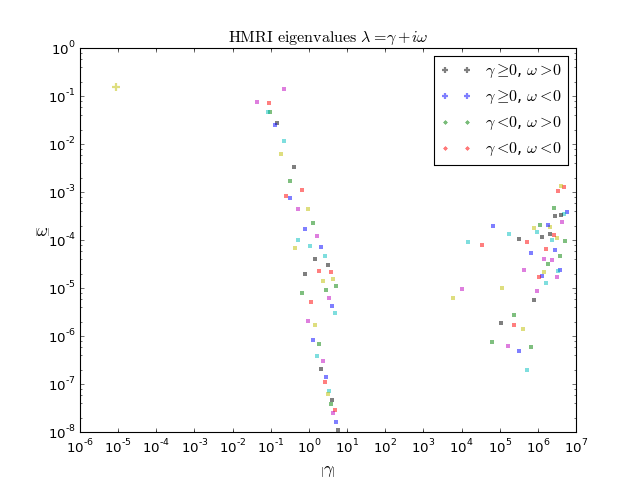

Number of positive real parts 1


In [17]:
print("There are {} goodeigs".format(len(goodeigs)))
print(goodeigs)
plt.figure()
ploteigs(goodeigs)

In [18]:
marginal_mode_index = np.where(np.abs(goodeigs.real) == np.nanmin(np.abs(goodeigs.real)))[0][0]
use_indx = int(goodeigs_indices[marginal_mode_index])

print(goodeigs[marginal_mode_index])
print(goodeigs[goodeigs.real > 0])
print(goodeigs[goodeigs.imag == np.max(goodeigs.imag)])

(9.04934254753e-06+0.152727355751j)
[  9.04934255e-06+0.15272736j]
[  9.04934255e-06+0.15272736j]


/Users/susanclark/dedalus_upgraded2/dedalus/lib/python3.5/site-packages/ipykernel/__main__.py:2: ComplexWarning: Casting complex values to real discards the imaginary part
  from ipykernel import kernelapp as app


In [19]:
rr  = r_shortgrid.grid()
evector = widegap_solver1.eigenvectors[use_indx]
widegap_solver1.set_state(use_indx)
data = widegap_solver1.state

<IPython.core.display.Javascript object>


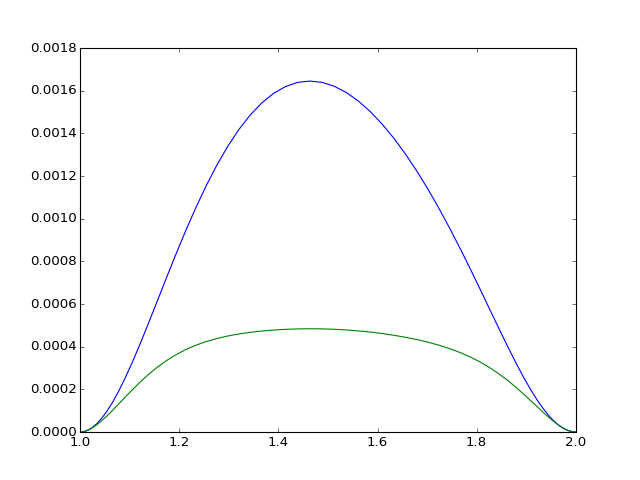

In [20]:
plt.figure()
plt.plot(rr, (data['psi']['g']).real, label='real')
plt.plot(rr, (data['psi']['g']).imag, label='imag')

<IPython.core.display.Javascript object>


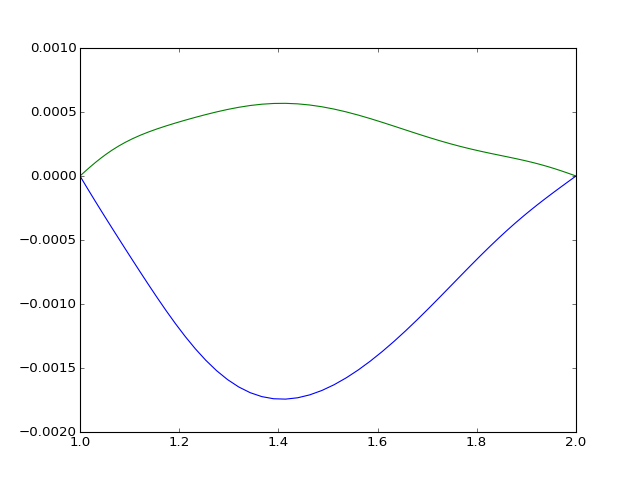

In [21]:
plt.figure()
plt.plot(rr, (data['u']['g']).real, label='real')
plt.plot(rr, (data['u']['g']).imag, label='imag')

<IPython.core.display.Javascript object>


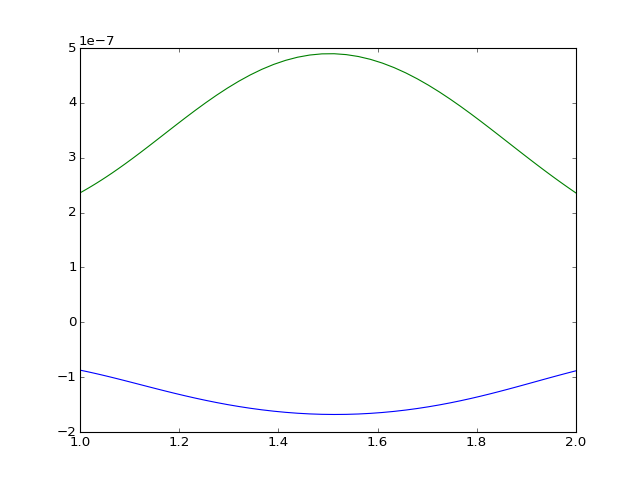

In [22]:
plt.figure()
plt.plot(rr, (data['A']['g']).real, label='real')
plt.plot(rr, (data['A']['g']).imag, label='imag')

<IPython.core.display.Javascript object>


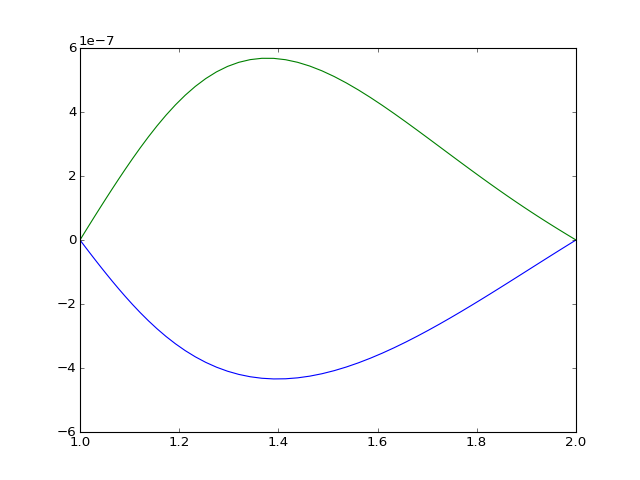

In [23]:
plt.figure()
plt.plot(rr, (data['B']['g']).real, label='real')
plt.plot(rr, (data['B']['g']).imag, label='imag')